In [1]:
import os.path as osp

import numpy as np
import pandas as pd
from collections import defaultdict

import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F

import torch_geometric.transforms as T
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import SplineConv
from torch_geometric.typing import WITH_TORCH_SPLINE_CONV
from torch_geometric.data import Dataset, Data

/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:54: UserWarning: An issue occurred while importing 'pyg-lib'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so, 0x0006): Library not loaded: /Library/Frameworks/Python.framework/Versions/3.12/Python
  Referenced from: <7BF3ABB0-5875-3736-8AB2-1784D3EFB687> /opt/anaconda3/envs/pyg/lib/python3.12/site-packages/libpyg.so
  Reason: tried: '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/System/Volumes/Preboot/Cryptexes/OS/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file), '/Library/Frameworks/Python.framework/Versions/3.12/Python' (no such file)
  warnings.warn(f"An issue occurred while importing 'pyg-lib'. "
/opt/anaconda3/envs/pyg/lib/python3.12/site-packages/torch_geometric/typing.py:110: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: dlopen(/opt/anaconda3/

In [2]:
if not WITH_TORCH_SPLINE_CONV:
    quit("This example requires 'torch-spline-conv'")
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:
dataset = 'Cora'
transform = T.Compose([
    T.RandomNodeSplit(num_val=2000, num_test=500),
    T.TargetIndegree(),
])
path = ('./dataset/cora')
dataset = Planetoid(path, dataset, transform=transform)
data = dataset[0]
print("Number of graphs in the dataset:", data)

Number of graphs in the dataset: Data(x=[2708, 1433], edge_index=[2, 10556], y=[2708], train_mask=[2708], val_mask=[2708], test_mask=[2708], edge_attr=[10556, 1])


In [3]:
filename = './dataset/NDD/physics_allparticle_044700.vtk'

In [4]:
"""
This function `read_mesh(filename)` processes a VTK file containing mesh data to extract points, elements, and scalar values.

Steps:
1. **Parse Points**:
   - Reads the coordinates of points from the VTK file.
   - Handles potential duplicate points by removing duplicates and mapping original indices to the new unique points.

2. **Extract Scalar Values (`phi`)**:
   - Reads scalar values (e.g., `phi`) associated with each point from the POINT_DATA section of the VTK file.
   - Averages scalar values if there are duplicate points.

3. **Parse Elements**:
   - Reads elements (cells) and remaps their point indices to match the deduplicated points.

4. **Compute Edges and Attributes**:
   - Identifies edges by connecting nodes within each element.
   - Computes attributes for each edge, such as the Euclidean distance between connected nodes.
   - All edges are included regardless of length.

5. **Return Values**:
   - `unique_points`: Array of deduplicated point coordinates.
   - `deduplicated_phi`: Scalar values associated with the deduplicated points.
   - `elements`: Array of elements with remapped point indices.
   - `edge_attributes`: DataFrame containing edge connections (node pairs) and their computed distances.

Usage:
- Call this function with the path to a VTK file to extract and process the mesh data.
- The returned data can be used for further mesh analysis, visualization, or as input to other computational methods.
"""

def is_point_on_segment(p, q, r, tolerance=1e-6):
    """Check if point r lies on the line segment pq."""
    # Check if r is collinear with p and q
    collinear = np.isclose(np.cross(q - p, r - p), 0, atol=tolerance)
    if not collinear:
        return False
    
    # Check if r is within the bounds of the segment pq
    within_bounds = np.all(r >= np.minimum(p, q)) and np.all(r <= np.maximum(p, q))
    return within_bounds

def grid_hash(points, grid_size=1.0):
    """Hashes points into a spatial grid."""
    grid = defaultdict(list)
    for idx, point in enumerate(points):
        grid_key = (int(point[0] // grid_size), int(point[1] // grid_size))
        grid[grid_key].append(idx)
    return grid

def get_nearby_points(p, q, grid, points, grid_size=1.0):
    """Returns points in grid cells near the line segment pq."""
    p_grid_key = (int(p[0] // grid_size), int(p[1] // grid_size))
    q_grid_key = (int(q[0] // grid_size), int(q[1] // grid_size))
    
    min_key = (min(p_grid_key[0], q_grid_key[0]), min(p_grid_key[1], q_grid_key[1]))
    max_key = (max(p_grid_key[0], q_grid_key[0]), max(p_grid_key[1], q_grid_key[1]))

    nearby_points = []
    for i in range(min_key[0], max_key[0] + 1):
        for j in range(min_key[1], max_key[1] + 1):
            if (i, j) in grid:
                nearby_points.extend(grid[(i, j)])
    return nearby_points

def split_edge_by_nodes(edge, points, grid, grid_size=1.0):
    """Split an edge if any nodes with odd coordinates lie on it."""
    p, q = edge
    split_points = [p]
    
    nearby_points = get_nearby_points(points[p], points[q], grid, points, grid_size)
    for r in nearby_points:
        if is_point_on_segment(points[p], points[q], points[r]):
            # print(f"Splitting edge {p}-{q} at point {r}")  # Diagnostic print
            split_points.append(r)
    
    split_points.append(q)
    split_points = sorted(set(split_points), key=lambda idx: np.linalg.norm(points[split_points[0]] - points[idx]))
    
    return [(split_points[i], split_points[i + 1]) for i in range(len(split_points) - 1)]

def read_mesh(filename, grid_size=1.0):
    with open(filename, 'r') as file:
        lines = file.readlines()

    # Parse points and handle potential duplicates
    points_start = lines.index(next(line for line in lines if 'POINTS' in line))
    num_points = int(lines[points_start].split()[1])
    points_end = points_start + 1 + num_points

    raw_points = []
    for line in lines[points_start + 1:points_end]:
        x, y, _ = map(float, line.strip().split())
        raw_points.append([x, y])
    raw_points = np.array(raw_points)

    # Remove duplicates from points array and map original indices to new indices
    unique_points, indices = np.unique(raw_points, axis=0, return_inverse=True)

    # Initialize dictionary to store all scalar fields
    scalar_fields = {}

    # Loop through all scalar fields in the VTK file
    i = 0
    while i < len(lines):
        if 'SCALARS' in lines[i]:
            # Extract the scalar field name
            field_name = lines[i].split()[1]
            # Find the lookup table start for this scalar field
            lookup_table_start = i + 2  # SCALARS + 1 line + LOOKUP_TABLE line
            values = []
            for j in range(lookup_table_start, lookup_table_start + num_points):
                values.append(float(lines[j].strip()))
            scalar_fields[field_name] = np.array(values)
            i = lookup_table_start + num_points  # Move index forward to next scalar field
        else:
            i += 1

    # Combine scalar values for duplicated points (e.g., averaging)
    deduplicated_data = {}
    for name, data in scalar_fields.items():
        deduplicated_values = np.zeros(len(unique_points))
        count = np.zeros(len(unique_points))
        for i, idx in enumerate(indices):
            deduplicated_values[idx] += data[i]
            count[idx] += 1
        deduplicated_values /= count  # Average the values for duplicates
        deduplicated_data[name] = deduplicated_values

    # Read elements and remap their point indices to the deduplicated indices
    cells_start = lines.index(next(line for line in lines if 'CELLS' in line))
    num_cells = int(lines[cells_start].split()[1])
    cells_end = cells_start + 1 + num_cells

    elements = []
    for line in lines[cells_start + 1:cells_end]:
        data = list(map(int, line.strip().split()))
        remapped_data = [indices[idx] for idx in data[1:1+data[0]]]
        elements.append(remapped_data)
    elements = np.array(elements)

    # Create spatial hash grid
    grid = grid_hash(unique_points, grid_size)
    
    # Compute edges and their attributes
    edges = set()
    for element in elements:
        for i in range(len(element)):
            a, b = sorted([element[i], element[(i + 1) % len(element)]])
            edges.add((a, b))

    # Check and split edges where necessary
    new_edges = set()
    total_edges = len(edges)
    for i, edge in enumerate(edges):
        if i % 100 == 0:  # Print progress every 100 edges
            print(f"Processing edge {i + 1}/{total_edges} ({(i + 1) / total_edges * 100:.2f}%)")
        
        split_edges = split_edge_by_nodes(edge, unique_points, grid, grid_size)
        new_edges.update(split_edges)

    edge_attributes = []
    for a, b in new_edges:
        dx, dy = unique_points[a] - unique_points[b]
        distance = np.sqrt(dx**2 + dy**2)
        edge_attributes.append([a, b, distance])
    
    edge_attributes = pd.DataFrame(edge_attributes, columns=['node1', 'node2', 'distance'])
    
    return unique_points, deduplicated_data, elements, edge_attributes

# Usage
points, point_data, elements, edge_attributes = read_mesh('./dataset/NDD/physics_allparticle_044600.vtk')
print("Points (deduplicated):", points)
print("Scalar Fields:", point_data)
print("Elements (remapped indices):", elements)
print("Edge Attributes:", edge_attributes)


Processing edge 1/26248 (0.00%)
Splitting edge 3014-3015 at point 3014
Splitting edge 3014-3015 at point 3015
Splitting edge 8208-8336 at point 8208
Splitting edge 8208-8336 at point 8336
Splitting edge 5859-5860 at point 5859
Splitting edge 5859-5860 at point 5860
Splitting edge 1544-1639 at point 1544
Splitting edge 1544-1639 at point 1639
Splitting edge 7765-7766 at point 7765
Splitting edge 7765-7766 at point 7766
Splitting edge 7751-7868 at point 7751
Splitting edge 7751-7868 at point 7868
Splitting edge 5495-5583 at point 5495
Splitting edge 5495-5583 at point 5583
Splitting edge 6388-6389 at point 6388
Splitting edge 6388-6389 at point 6389
Splitting edge 11139-11140 at point 11139
Splitting edge 11139-11140 at point 11140
Splitting edge 9762-9763 at point 9762
Splitting edge 9762-9763 at point 9763
Splitting edge 2281-2282 at point 2281
Splitting edge 2281-2282 at point 2282
Splitting edge 904-905 at point 904
Splitting edge 904-905 at point 905
Splitting edge 2552-2553 at poin

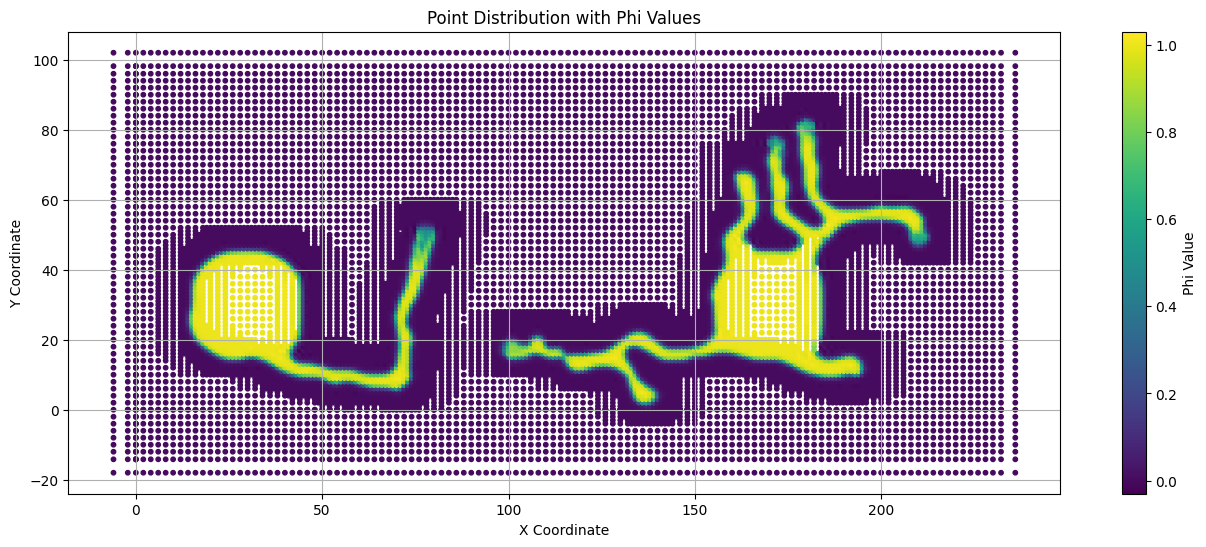

In [9]:
# Assuming 'points' is an Nx2 NumPy array and 'phi' is a 1D array with N elements
# 'edge_attributes' is assumed to be a DataFrame with columns 'node1' and 'node2'

def plot_points_with_scalar_values(points, phi):
    plt.figure(figsize=(16, 6))
    scatter = plt.scatter(points[:, 0], points[:, 1], c=phi, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Phi Value')
    plt.title('Point Distribution with Phi Values')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def plot_edges(points, edges):
    plt.figure(figsize=(13, 6))
    # Plot edges
    for edge in edges:
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        plt.plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], 'k-', linewidth=1)  # 'k-' for black edges
    
    plt.title('Edge Distribution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# phi = np.array(point_data['phi'])
phi = np.array(point_data['phi'])
syn = np.array(point_data['synaptogenesis'])
tub = np.array(point_data['tubulin'])
tip = np.array(point_data['tips'])
the = np.array(point_data['theta'])

# Correct usage example:
plot_points_with_scalar_values(points, np.round(phi, decimals=2))  # ensure 'phi' is correctly defined
# plot_points_with_scalar_values(points, np.round(syn, decimals=2))  # ensure 'phi' is correctly defined
# plot_points_with_scalar_values(points, np.round(tub, decimals=2))  # ensure 'phi' is correctly defined
# plot_points_with_scalar_values(points, np.round(tip, decimals=2))  # ensure 'phi' is correctly defined
# plot_points_with_scalar_values(points, np.round(the, decimals=2))  # ensure 'phi' is correctly defined
plot_edges(points, edge_attributes[['node1', 'node2']].values)


In [ ]:
import matplotlib.pyplot as plt

print(len(points))
print(len(edge_attributes))

def plot_points_with_scalar_values(points, phi):
    plt.figure(figsize=(16, 6))
    scatter = plt.scatter(points[:, 0], points[:, 1], c=phi, cmap='viridis', s=10)
    plt.colorbar(scatter, label='Phi Value')
    plt.title('Point Distribution with Phi Values')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

def plot_edges(points, edges):
    plt.figure(figsize=(13, 6))
    
    # Plot edges
    for edge in edges:
        point_a = points[edge[0]]
        point_b = points[edge[1]]
        plt.plot([point_a[0], point_b[0]], [point_a[1], point_b[1]], 'k-', linewidth=1)  # 'r-' for red edges
    
    plt.title('Edge Distribution')
    plt.xlabel('X Coordinate')
    plt.ylabel('Y Coordinate')
    plt.grid(True)
    plt.show()

# Example usage:
plot_points_with_scalar_values(points, np.round(phi, decimals=2))
plot_edges(points, edge_attributes[['node1', 'node2']].values)

In [ ]:
import torch
import numpy as np
from torch_geometric.data import Data

def create_graph_data(points, elements, var):
    # Convert points and target variable to tensors
    x = torch.tensor(points, dtype=torch.float)  # Node features based on coordinates
    y = torch.tensor(var, dtype=torch.float)     # Target variable per node

    edges = set()
    for element in elements:
        num_vertices = len(element)
        # Loop through each pair of vertices and connect them
        for i in range(num_vertices):
            # Connect vertex i to i+1, and the last vertex back to the first
            a, b = element[i], element[(i + 1) % num_vertices]
            if a > b:  # Ensure consistent ordering (smaller id first)
                a, b = b, a
            edges.add((a, b))

    # Convert set of edges into a tensor of shape [2, num_edges]
    edge_index = torch.tensor(list(edges), dtype=torch.long).t()

    # Calculate edge attributes, e.g., Euclidean distance between connected nodes
    edge_attr = []
    for i in range(edge_index.size(1)):
        start, end = edge_index[:, i]
        distance = np.linalg.norm(np.array(points[start]) - np.array(points[end]))
        edge_attr.append(distance)

    edge_attr = torch.tensor(edge_attr, dtype=torch.float).view(-1, 1)  # Shape as [E, 1] directly

    # Create the graph data object
    data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y)
    # data.num_nodes = len(points)  # Set total number of nodes

    return data

# Create the graph data object
data = create_graph_data(points, elements, phi)

# Print the graph data object
print(data)

Data(x=[13223, 2], edge_index=[2, 26248], edge_attr=[26248, 1], y=[13223])


In [ ]:
# Ensure y (labels) is of shape [num_nodes]
data.y = data.y.view(-1)  # Ensure y is 1D [num_nodes]

# Number of nodes in the graph
num_nodes = data.x.size(0)  # Infer the number of nodes from x
num_train = int(num_nodes * 0.8)  # 80% of nodes for training
num_test = num_nodes - num_train  # 20% of nodes for testing

# Randomly permute node indices to create random train, validation, and test splits
perm = torch.randperm(num_nodes)

# Initialize masks for train and test sets
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Assign masks based on the random permutation
train_mask[perm[:num_train]] = True
test_mask[perm[num_train:]] = True

# Assign masks to the Data object
data.train_mask = train_mask
data.test_mask = test_mask

# Optional: Create a validation mask from the training set
num_val = int(num_train * 0.1)  # 10% of the training set for validation
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask[perm[:num_val]] = True

# Assign validation mask to the Data object
data.val_mask = val_mask

data.num_classes = 2  # Assuming your problem is binary classification

data.y = data.y.long()
# Print the final structured data object
print(data)

Data(x=[13223, 2], edge_index=[2, 26248], edge_attr=[26248, 1], y=[13223], train_mask=[13223], test_mask=[13223], val_mask=[13223], num_classes=2)


In [ ]:
class Net(torch.nn.Module):
    def __init__(self, dataset):
        super().__init__()
        self.conv1 = SplineConv(dataset.num_features, 16, dim=1, kernel_size=2, is_open_spline=False, degree=1, aggr="mean", root_weight=True, bias=False)
        self.conv2 = SplineConv(16, dataset.num_classes, dim=1, kernel_size=2, is_open_spline=False, degree=1, aggr="mean", root_weight=True, bias=False)

    def forward(self, data):  # Ensure `data` is an argument here
        x, edge_index, edge_attr = data.x, data.edge_index, data.edge_attr
        x = F.dropout(x, training=self.training)
        x = F.elu(self.conv1(x, edge_index, edge_attr))
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index, edge_attr)
        return F.log_softmax(x, dim=1)

def train():
    model.train()
    optimizer.zero_grad()
    out = model(data)  # Pass the data object to the model
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])  # Compute the loss
    loss.backward()
    optimizer.step()

@torch.no_grad()
def test():
    model.eval()
    log_probs, accs = model(data), []  # Pass the data object to the model
    for _, mask in data('train_mask', 'test_mask'):
        pred = log_probs[mask].max(1)[1]
        acc = pred.eq(data.y[mask]).sum().item() / mask.sum().item()
        accs.append(acc)
    return accs

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data.num_classes = 2  # Assuming your problem is binary classification

# Pass the `data` object to the `Net` class when creating the model
model = Net(data).to(device)

data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-3)

# Lists to store training and test accuracy for each epoch
train_acc_list = []
test_acc_list = []

for epoch in range(1, 101):
    train()
    train_acc, test_acc = test()
    train_acc_list.append(train_acc)
    test_acc_list.append(test_acc)
    print(f'Epoch: {epoch:03d}, Train: {train_acc:.4f}, Test: {test_acc:.4f}')


Epoch: 001, Train: 0.9638, Test: 0.9626
Epoch: 002, Train: 0.9656, Test: 0.9641
Epoch: 003, Train: 0.9668, Test: 0.9656
Epoch: 004, Train: 0.9677, Test: 0.9667
Epoch: 005, Train: 0.9695, Test: 0.9682
Epoch: 006, Train: 0.9711, Test: 0.9705
Epoch: 007, Train: 0.9720, Test: 0.9713
Epoch: 008, Train: 0.9726, Test: 0.9720
Epoch: 009, Train: 0.9730, Test: 0.9728
Epoch: 010, Train: 0.9733, Test: 0.9732
Epoch: 011, Train: 0.9735, Test: 0.9735
Epoch: 012, Train: 0.9736, Test: 0.9735
Epoch: 013, Train: 0.9736, Test: 0.9739
Epoch: 014, Train: 0.9736, Test: 0.9739
Epoch: 015, Train: 0.9736, Test: 0.9739
Epoch: 016, Train: 0.9735, Test: 0.9732
Epoch: 017, Train: 0.9732, Test: 0.9732
Epoch: 018, Train: 0.9729, Test: 0.9724
Epoch: 019, Train: 0.9720, Test: 0.9720
Epoch: 020, Train: 0.9710, Test: 0.9705
Epoch: 021, Train: 0.9690, Test: 0.9671
Epoch: 022, Train: 0.9681, Test: 0.9660
Epoch: 023, Train: 0.9681, Test: 0.9664
Epoch: 024, Train: 0.9681, Test: 0.9667
Epoch: 025, Train: 0.9683, Test: 0.9664


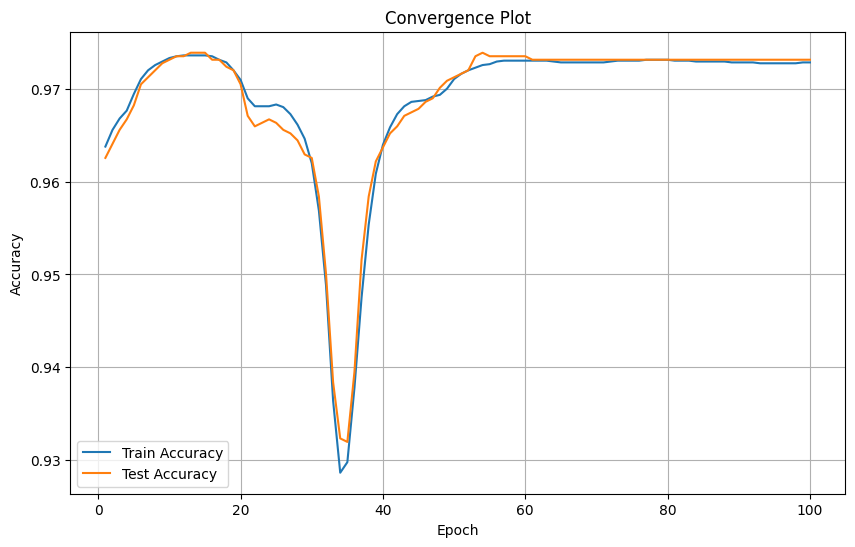

In [37]:
# Plot the convergence of training and test accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, 101), train_acc_list, label='Train Accuracy')
plt.plot(range(1, 101), test_acc_list, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Convergence Plot')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
@torch.no_grad()
def evaluate_model(data, model):
    model.eval()  # Set the model to evaluation mode
    out = model(data)  # Get the output of the model (log probabilities)
    
    # Get the predicted classes and actual classes for the test set
    pred = out[data.test_mask].max(1)[1]  # Get the index of the max log-probability
    actual = data.y[data.test_mask]  # Actual labels
    
    # Calculate accuracy
    correct = pred.eq(actual).sum().item()  # Count of correct predictions
    total = data.test_mask.sum().item()  # Total number of test samples
    accuracy = correct / total  # Accuracy as a ratio
    
    print(f'Test Accuracy: {accuracy:.4f}')
    
    # Print a few sample predictions versus actual values
    print("\nSample Predictions:")
    num_samples = min(10, len(pred))  # Show up to 10 samples
    for i in range(num_samples):
        print(f'Predicted: {pred[i].item()}, Actual: {actual[i].item()}')

# Call the evaluation function after training is complete
evaluate_model(data, model)


Test Accuracy: 0.9732

Sample Predictions:
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 0, Actual: